In [1318]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import joblib

In [1319]:
import pandas as pd

# We'll also import seaborn, a Python graphing library
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", color_codes=True)


data=pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [1320]:
diabetes_data_copy = data.copy(deep = True)
diabetes_data_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = diabetes_data_copy[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.nan)


## showing the count of Nans
print(diabetes_data_copy.isnull().sum())



diabetes_data_copy['Glucose'].fillna(diabetes_data_copy['Glucose'].mean(), inplace = True)
diabetes_data_copy['BloodPressure'].fillna(diabetes_data_copy['BloodPressure'].mean(), inplace = True)
diabetes_data_copy['SkinThickness'].fillna(diabetes_data_copy['SkinThickness'].median(), inplace = True)
diabetes_data_copy['Insulin'].fillna(diabetes_data_copy['Insulin'].median(), inplace = True)
diabetes_data_copy['BMI'].fillna(diabetes_data_copy['BMI'].median(), inplace = True)

results = {
    'Model': [],
    'F1': [],
    'Accuracy': [],
    'AUC': [],
    'Specificity': [],
    'Precision': [],
    'Recall': [],
}

cross_results = {
    'Model': [],
    'F1': [],
    'Accuracy': [],
    'AUC': [],
    'Precision': [],
    'Recall': [],
}


Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


# 1. MLP

Doğruluk (Accuracy): 0.6883
Specificity: 0.7933
Kesinlik (Precision): 0.5634
Duyarlılık (Sensitivity/Recall): 0.4938
F1 Skoru: 0.5263


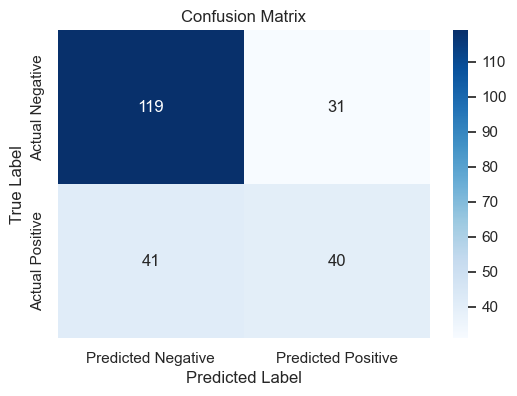

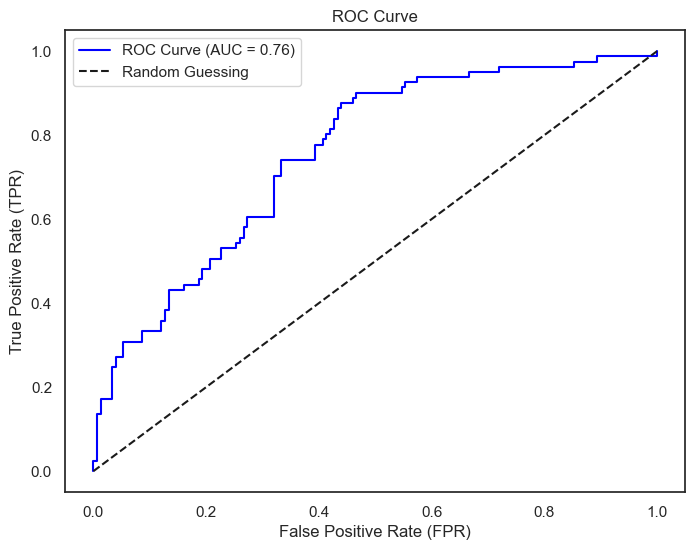

Cross Doğruluk (Accuracy): 0.6770
Cross Kesinlik (Precision): 0.6309
Cross Duyarlılık (Sensitivity/Recall): 0.3524
Cross F1 Skoru: 0.3986
Cross AUC: 0.6778


In [ ]:
# Gerekli kütüphaneleri import edelim
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_sample_weight

# 1. Split FIRST (to avoid data leakage)
X = diabetes_data_copy.drop("Outcome", axis=1)
y = diabetes_data_copy["Outcome"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Class weight hesapla
classes_weights = class_weight.compute_class_weight('balanced', 
                                                 classes=np.unique(y_train), 
                                                 y=y_train)
weights = {0: classes_weights[0], 1: classes_weights[1]}

# 2. Initialize and fit scaler ONLY on training data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit only on train
X_test_scaled = scaler.transform(X_test)        # Transform test data

joblib.dump(scaler, 'scaler.pkl')

# 3. Create and train MLP
mlp = MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=5000, random_state=42)

# 4. Train the model
mlp.fit(X_train_scaled, y_train)

# 5. Evaluate
predictions = mlp.predict(X_test_scaled)

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)
tn, fp, fn, tp = cm.ravel()

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print(f"Doğruluk (Accuracy): {accuracy:.4f}")

# Calculate specificity
specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

from sklearn.metrics import precision_score
precision = precision_score(y_test, predictions)
print(f"Kesinlik (Precision): {precision:.4f}")

from sklearn.metrics import recall_score
sensitivity = recall_score(y_test, predictions)
print(f"Duyarlılık (Sensitivity/Recall): {sensitivity:.4f}")

from sklearn.metrics import f1_score
f1 = f1_score(y_test, predictions)
print(f"F1 Skoru: {f1:.4f}")

# Append scores to results
results['Model'].append("MLP")
results['Accuracy'].append(accuracy)
results['Specificity'].append(specificity)
results['Precision'].append(precision)
results['Recall'].append(sensitivity)
results['F1'].append(f1)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Get predicted probabilities for the positive class
y_probs = mlp.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)
results['AUC'].append(auc_score)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cross_accuracy = cross_val_score(mlp, X, y, cv=skf, scoring='accuracy')
cross_precision = cross_val_score(mlp, X, y, cv=skf, scoring='precision')
cross_sensitivity = cross_val_score(mlp, X, y, cv=skf, scoring='recall')
cross_f1 = cross_val_score(mlp, X, y, cv=skf, scoring='f1')
cross_auc_score = cross_val_score(mlp, X, y, cv=skf, scoring='roc_auc')

mean_accuracy = cross_accuracy.mean()
mean_precision = cross_precision.mean()
mean_sensitivity = cross_sensitivity.mean()
mean_f1 = cross_f1.mean()
mean_auc_score = cross_auc_score.mean()


# Append scores to results
cross_results['Model'].append("MLP")
cross_results['Accuracy'].append(mean_accuracy)
cross_results['Precision'].append(mean_precision)
cross_results['Recall'].append(mean_sensitivity)
cross_results['F1'].append(mean_f1)
cross_results['AUC'].append(mean_auc_score)


print(f"Cross Doğruluk (Accuracy): {mean_accuracy:.4f}")
print(f"Cross Kesinlik (Precision): {mean_precision:.4f}")
print(f"Cross Duyarlılık (Sensitivity/Recall): {mean_sensitivity:.4f}")
print(f"Cross F1 Skoru: {mean_f1:.4f}")
print(f"Cross AUC: {mean_auc_score:.4f}")

## 1.1. MLP (PCA)

Original data shape: (768, 8)
Reduced data shape: (537, 1)
Explained variance ratio: [0.29067411]
Doğruluk (Accuracy): 0.7143
Specificity: 0.8600
Kesinlik (Precision): 0.6316
Duyarlılık (Sensitivity/Recall): 0.4444
F1 Skoru: 0.5217


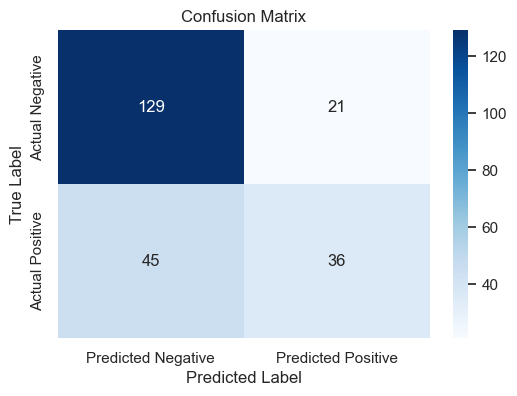

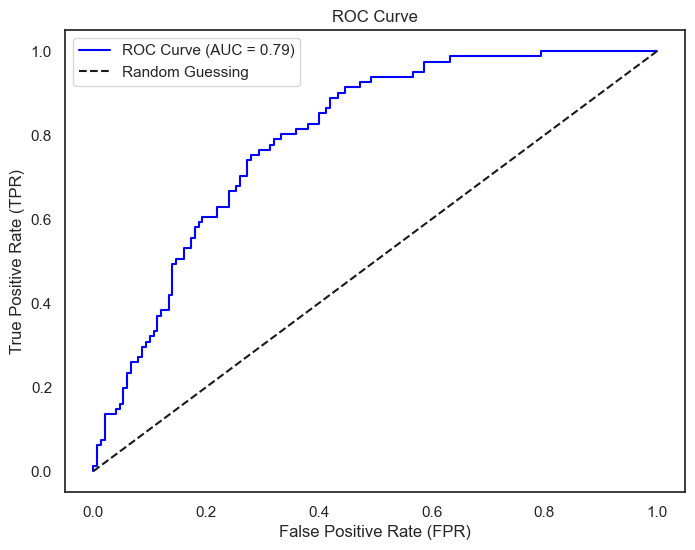

Cross Doğruluk (Accuracy): 0.6770
Cross Kesinlik (Precision): 0.6309
Cross Duyarlılık (Sensitivity/Recall): 0.3524
Cross F1 Skoru: 0.3986
Cross AUC: 0.6778


In [ ]:
from sklearn.decomposition import PCA


# Apply PCA
n_components = 1  # Number of principal components to keep
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

joblib.dump(pca, 'pca.pkl')

print("Original data shape:", X.shape)
print("Reduced data shape:", X_train_pca.shape)
print("Explained variance ratio:", pca.explained_variance_ratio_)


# MLP modelini oluşturalım
mlp = MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=5000, random_state=42)
# hidden_layer_sizes: Her bir tuple elemanı bir gizli katmanı ve nöron sayısını temsil eder
# Bu örnekte 3 gizli katman, her birinde 10 nöron var

# Modeli eğitelim
mlp.fit(X_train_pca, y_train)

# Tahminler yapalım
predictions = mlp.predict(X_test_pca)

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, predictions)
print(f"Doğruluk (Accuracy): {accuracy:.4f}")

specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

precision = precision_score(y_test, predictions)
print(f"Kesinlik (Precision): {precision:.4f}")

sensitivity = recall_score(y_test, predictions)
print(f"Duyarlılık (Sensitivity/Recall): {sensitivity:.4f}")

f1 = f1_score(y_test, predictions)
print(f"F1 Skoru: {f1:.4f}")

# Append scores to results
results['Model'].append("MLP (PCA)")
results['Accuracy'].append(accuracy)
results['Specificity'].append(specificity)
results['Precision'].append(precision)
results['Recall'].append(sensitivity)
results['F1'].append(f1)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Get predicted probabilities for the positive class
y_probs = mlp.predict_proba(X_test_pca)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)
results['AUC'].append(auc_score)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()

## 1.3. MLP (LDA)

Original data shape: (768, 8)
Reduced data shape: (537, 1)
Doğruluk (Accuracy): 0.7229
Specificity: 0.8667
Kesinlik (Precision): 0.6491
Duyarlılık (Sensitivity/Recall): 0.4568
F1 Skoru: 0.5362


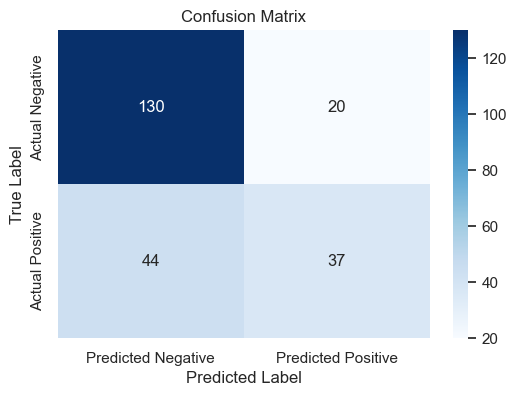

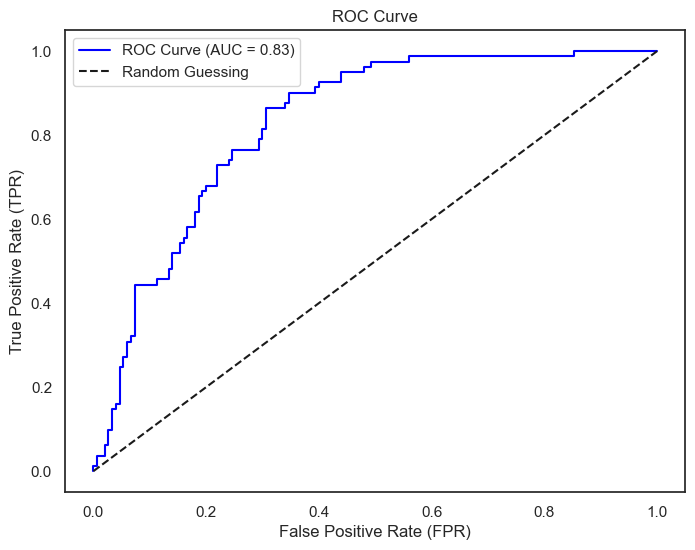

In [1323]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
import numpy as np


# Apply LDA
n_components = 1  # Number of components to keep (cannot be greater than n_classes - 1)
lda = LinearDiscriminantAnalysis(n_components=n_components)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

joblib.dump(lda, 'lda.pkl')

print("Original data shape:", X.shape)
print("Reduced data shape:", X_train_lda.shape)

# MLP modelini oluşturalım
mlp = MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=5000, random_state=42)

# hidden_layer_sizes: Her bir tuple elemanı bir gizli katmanı ve nöron sayısını temsil eder
# Bu örnekte 3 gizli katman, her birinde 10 nöron var

# Modeli eğitelim
mlp.fit(X_train_lda, y_train)

# Tahminler yapalım
predictions = mlp.predict(X_test_lda)

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, predictions)
print(f"Doğruluk (Accuracy): {accuracy:.4f}")

specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

precision = precision_score(y_test, predictions)
print(f"Kesinlik (Precision): {precision:.4f}")

sensitivity = recall_score(y_test, predictions)
print(f"Duyarlılık (Sensitivity/Recall): {sensitivity:.4f}")

f1 = f1_score(y_test, predictions)
print(f"F1 Skoru: {f1:.4f}")

# Append scores to results
results['Model'].append("MLP (LDA)")
results['Accuracy'].append(accuracy)
results['Specificity'].append(specificity)
results['Precision'].append(precision)
results['Recall'].append(sensitivity)
results['F1'].append(f1)


# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Get predicted probabilities for the positive class
y_probs = mlp.predict_proba(X_test_lda)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)
results['AUC'].append(auc_score)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()

# 2. Decision Tree

Doğruluk (Accuracy): 0.6883
Specificity: 0.7533
Kesinlik (Precision): 0.5542
Duyarlılık (Sensitivity/Recall): 0.5679
F1 Skoru: 0.5610


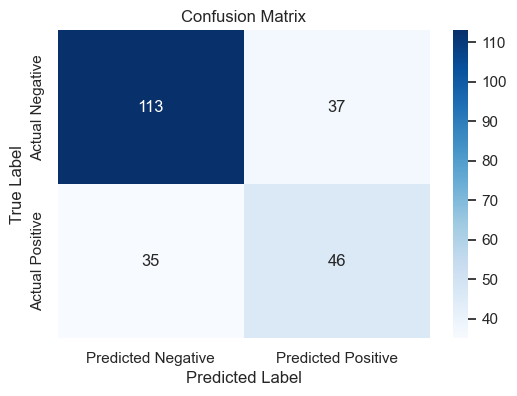

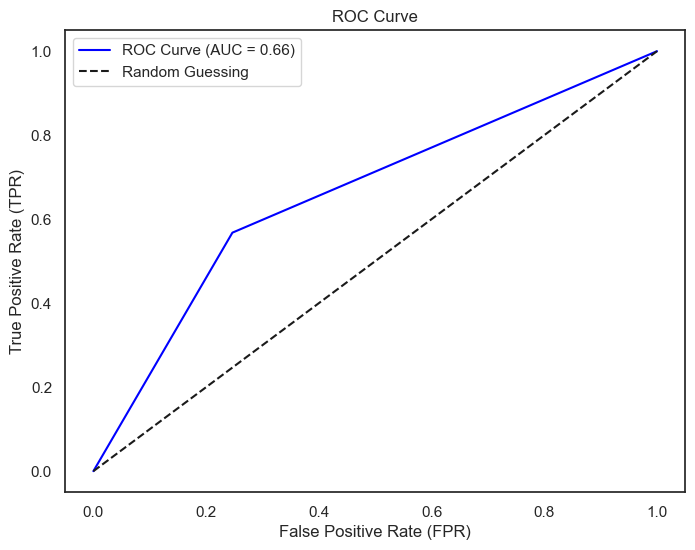

Cross Doğruluk (Accuracy): 0.6952
Cross Kesinlik (Precision): 0.5671
Cross Duyarlılık (Sensitivity/Recall): 0.5593
Cross F1 Skoru: 0.5607
Cross AUC: 0.6636


In [1324]:
from sklearn.tree import DecisionTreeClassifier

dt= DecisionTreeClassifier(class_weight=weights, random_state=42)
dt.fit(X_train_scaled,y_train)

# Make predictions on the testing set
predictions = dt.predict(X_test_scaled)

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, predictions)
print(f"Doğruluk (Accuracy): {accuracy:.4f}")

specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

precision = precision_score(y_test, predictions)
print(f"Kesinlik (Precision): {precision:.4f}")

sensitivity = recall_score(y_test, predictions)
print(f"Duyarlılık (Sensitivity/Recall): {sensitivity:.4f}")

f1 = f1_score(y_test, predictions)
print(f"F1 Skoru: {f1:.4f}")

# Append scores to results
results['Model'].append("Decision Tree")
results['Accuracy'].append(accuracy)
results['Specificity'].append(specificity)
results['Precision'].append(precision)
results['Recall'].append(sensitivity)
results['F1'].append(f1)


# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Get predicted probabilities for the positive class
y_probs = dt.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)
results['AUC'].append(auc_score)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()


cross_accuracy = cross_val_score(dt, X, y, cv=skf, scoring='accuracy')
cross_precision = cross_val_score(dt, X, y, cv=skf, scoring='precision')
cross_sensitivity = cross_val_score(dt, X, y, cv=skf, scoring='recall')
cross_f1 = cross_val_score(dt, X, y, cv=skf, scoring='f1')
cross_auc_score = cross_val_score(dt, X, y, cv=skf, scoring='roc_auc')

mean_accuracy = cross_accuracy.mean()
mean_precision = cross_precision.mean()
mean_sensitivity = cross_sensitivity.mean()
mean_f1 = cross_f1.mean()
mean_auc_score = cross_auc_score.mean()


# Append scores to results
cross_results['Model'].append("Decision Tree")
cross_results['Accuracy'].append(mean_accuracy)
cross_results['Precision'].append(mean_precision)
cross_results['Recall'].append(mean_sensitivity)
cross_results['F1'].append(mean_f1)
cross_results['AUC'].append(mean_auc_score)


print(f"Cross Doğruluk (Accuracy): {mean_accuracy:.4f}")
print(f"Cross Kesinlik (Precision): {mean_precision:.4f}")
print(f"Cross Duyarlılık (Sensitivity/Recall): {mean_sensitivity:.4f}")
print(f"Cross F1 Skoru: {mean_f1:.4f}")
print(f"Cross AUC: {mean_auc_score:.4f}")

## 2.1. Decision Tree (PCA)

Doğruluk (Accuracy): 0.6797
Specificity: 0.7933
Kesinlik (Precision): 0.5507
Duyarlılık (Sensitivity/Recall): 0.4691
F1 Skoru: 0.5067


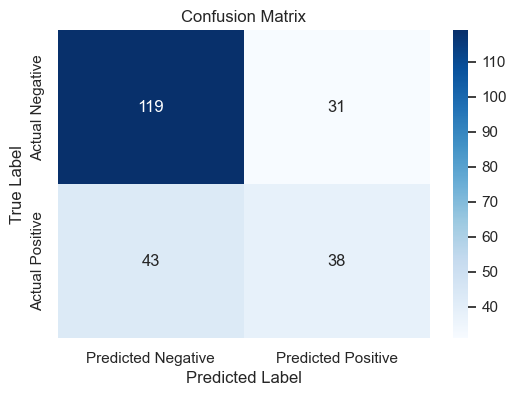

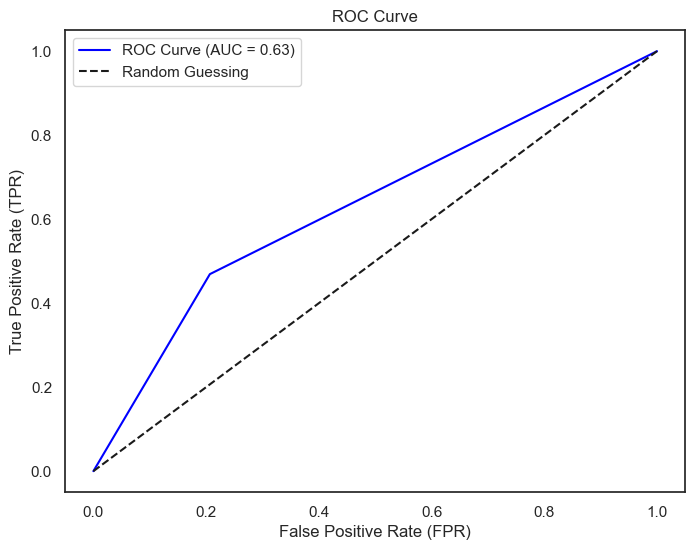

In [1325]:

from sklearn.tree import DecisionTreeClassifier

dt= DecisionTreeClassifier(class_weight=weights, random_state=42)
dt.fit(X_train_pca,y_train)


# Make predictions on the testing set
predictions = dt.predict(X_test_pca)

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, predictions)
print(f"Doğruluk (Accuracy): {accuracy:.4f}")

specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

precision = precision_score(y_test, predictions)
print(f"Kesinlik (Precision): {precision:.4f}")

sensitivity = recall_score(y_test, predictions)
print(f"Duyarlılık (Sensitivity/Recall): {sensitivity:.4f}")

f1 = f1_score(y_test, predictions)
print(f"F1 Skoru: {f1:.4f}")

# Append scores to results
results['Model'].append("Decision Tree (PCA)")
results['Accuracy'].append(accuracy)
results['Specificity'].append(specificity)
results['Precision'].append(precision)
results['Recall'].append(sensitivity)
results['F1'].append(f1)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Get predicted probabilities for the positive class
y_probs = dt.predict_proba(X_test_pca)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)
results['AUC'].append(auc_score)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()

## 2.3. Decision Tree (LDA)

Doğruluk (Accuracy): 0.7229
Specificity: 0.8000
Kesinlik (Precision): 0.6104
Duyarlılık (Sensitivity/Recall): 0.5802
F1 Skoru: 0.5949


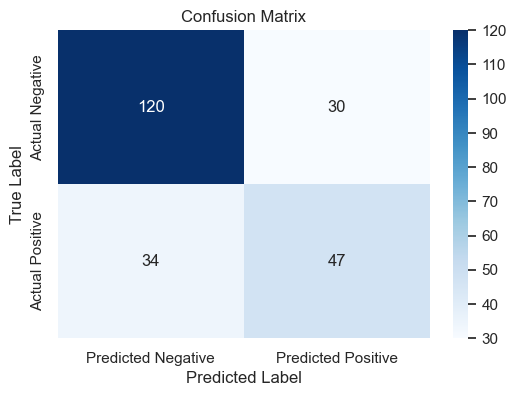

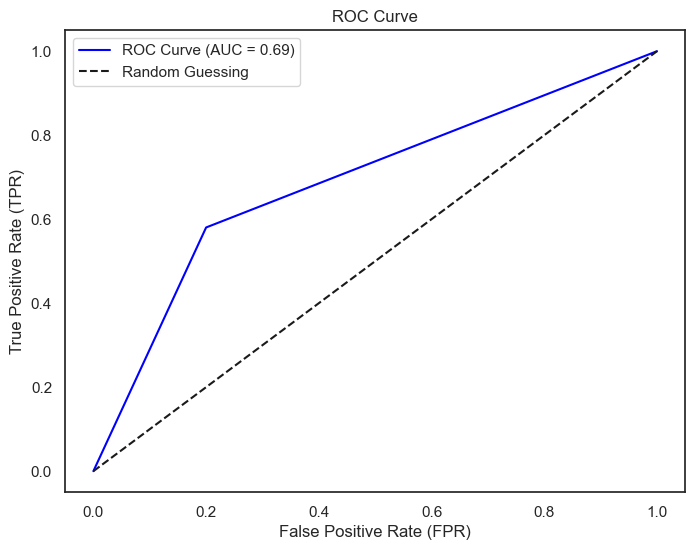

In [1326]:

from sklearn.tree import DecisionTreeClassifier
dt= DecisionTreeClassifier(class_weight=weights, random_state=42)
dt.fit(X_train_lda,y_train)


# Make predictions on the testing set
predictions = dt.predict(X_test_lda)

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, predictions)
print(f"Doğruluk (Accuracy): {accuracy:.4f}")

specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

precision = precision_score(y_test, predictions)
print(f"Kesinlik (Precision): {precision:.4f}")

sensitivity = recall_score(y_test, predictions)
print(f"Duyarlılık (Sensitivity/Recall): {sensitivity:.4f}")

f1 = f1_score(y_test, predictions)
print(f"F1 Skoru: {f1:.4f}")

# Append scores to results
results['Model'].append("Decision Tree (LDA)")
results['Accuracy'].append(accuracy)
results['Specificity'].append(specificity)
results['Precision'].append(precision)
results['Recall'].append(sensitivity)
results['F1'].append(f1)


# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Get predicted probabilities for the positive class
y_probs = dt.predict_proba(X_test_lda)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)
results['AUC'].append(auc_score)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()


# 3. K-NEAREST NEIGHBOR

Doğruluk (Accuracy): 0.7186
Specificity: 0.8133
Kesinlik (Precision): 0.6111
Duyarlılık (Sensitivity/Recall): 0.5432
F1 Skoru: 0.5752


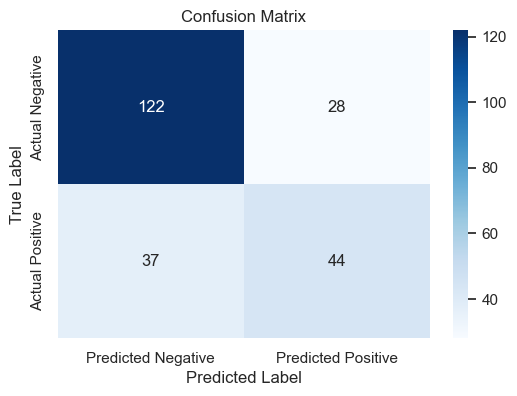

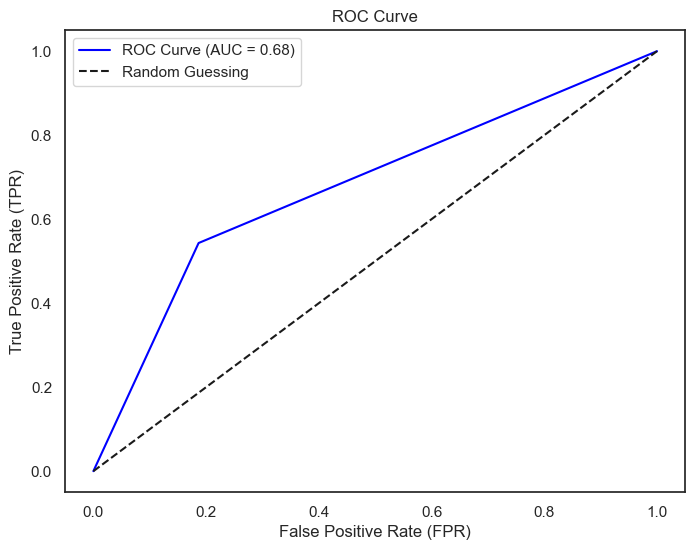

Cross Doğruluk (Accuracy): 0.6901
Cross Kesinlik (Precision): 0.5604
Cross Duyarlılık (Sensitivity/Recall): 0.5488
Cross F1 Skoru: 0.5523
Cross AUC: 0.6574


In [1327]:

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_scaled,y_train)

# Make predictions on the testing set
predictions = knn.predict(X_test_scaled)

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, predictions)
print(f"Doğruluk (Accuracy): {accuracy:.4f}")

specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

precision = precision_score(y_test, predictions)
print(f"Kesinlik (Precision): {precision:.4f}")

sensitivity = recall_score(y_test, predictions)
print(f"Duyarlılık (Sensitivity/Recall): {sensitivity:.4f}")

f1 = f1_score(y_test, predictions)
print(f"F1 Skoru: {f1:.4f}")

# Append scores to results
results['Model'].append("K-NEAREST NEIGHBOOR")
results['Accuracy'].append(accuracy)
results['Specificity'].append(specificity)
results['Precision'].append(precision)
results['Recall'].append(sensitivity)
results['F1'].append(f1)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Get predicted probabilities for the positive class
y_probs = knn.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)
results['AUC'].append(auc_score)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()


cross_accuracy = cross_val_score(knn, X, y, cv=skf, scoring='accuracy')
cross_precision = cross_val_score(knn, X, y, cv=skf, scoring='precision')
cross_sensitivity = cross_val_score(knn, X, y, cv=skf, scoring='recall')
cross_f1 = cross_val_score(knn, X, y, cv=skf, scoring='f1')
cross_auc_score = cross_val_score(knn, X, y, cv=skf, scoring='roc_auc')

mean_accuracy = cross_accuracy.mean()
mean_precision = cross_precision.mean()
mean_sensitivity = cross_sensitivity.mean()
mean_f1 = cross_f1.mean()
mean_auc_score = cross_auc_score.mean()


# Append scores to results
cross_results['Model'].append("K-NEAREST NEIGHBOR")
cross_results['Accuracy'].append(mean_accuracy)
cross_results['Precision'].append(mean_precision)
cross_results['Recall'].append(mean_sensitivity)
cross_results['F1'].append(mean_f1)
cross_results['AUC'].append(mean_auc_score)


print(f"Cross Doğruluk (Accuracy): {mean_accuracy:.4f}")
print(f"Cross Kesinlik (Precision): {mean_precision:.4f}")
print(f"Cross Duyarlılık (Sensitivity/Recall): {mean_sensitivity:.4f}")
print(f"Cross F1 Skoru: {mean_f1:.4f}")
print(f"Cross AUC: {mean_auc_score:.4f}")

## 3.1. K-NEAREST NEIGHBOOR (PCA)

Doğruluk (Accuracy): 0.6797
Specificity: 0.7933
Kesinlik (Precision): 0.5507
Duyarlılık (Sensitivity/Recall): 0.4691
F1 Skoru: 0.5067


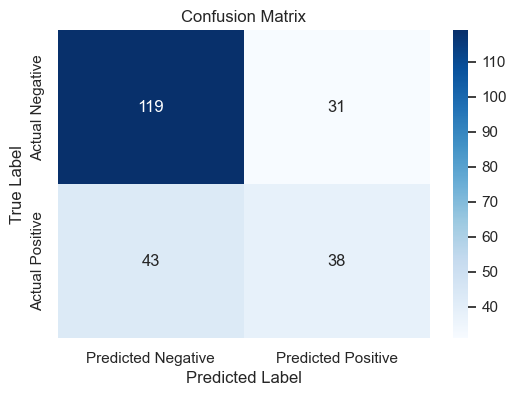

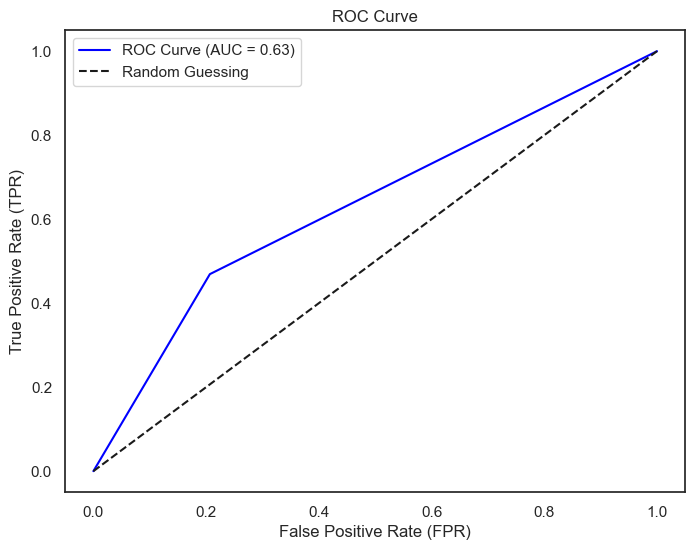

In [1328]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)

# Make predictions on the testing set
predictions = knn.predict(X_test_pca)

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, predictions)
print(f"Doğruluk (Accuracy): {accuracy:.4f}")

specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

precision = precision_score(y_test, predictions)
print(f"Kesinlik (Precision): {precision:.4f}")

sensitivity = recall_score(y_test, predictions)
print(f"Duyarlılık (Sensitivity/Recall): {sensitivity:.4f}")

f1 = f1_score(y_test, predictions)
print(f"F1 Skoru: {f1:.4f}")

# Append scores to results
results['Model'].append("K-NEAREST NEIGHBOOR (PCA)")
results['Accuracy'].append(accuracy)
results['Specificity'].append(specificity)
results['Precision'].append(precision)
results['Recall'].append(sensitivity)
results['F1'].append(f1)


# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Get predicted probabilities for the positive class
y_probs = knn.predict_proba(X_test_pca)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)
results['AUC'].append(auc_score)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()


## 3.1. K-NEAREST NEIGHBOOR (LDA)

Doğruluk (Accuracy): 0.7229
Specificity: 0.8000
Kesinlik (Precision): 0.6104
Duyarlılık (Sensitivity/Recall): 0.5802
F1 Skoru: 0.5949


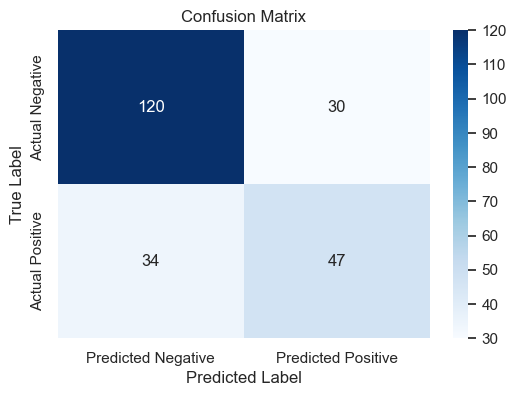

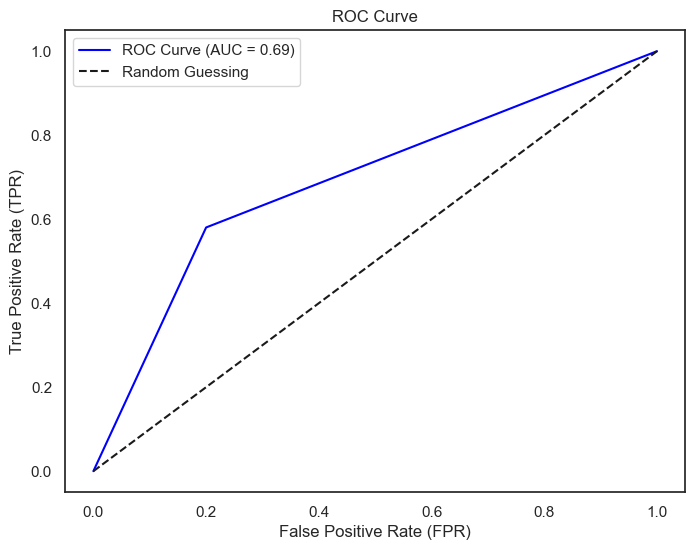

In [1329]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_lda, y_train)

# Make predictions on the testing set
predictions = knn.predict(X_test_lda)

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, predictions)
print(f"Doğruluk (Accuracy): {accuracy:.4f}")

specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

precision = precision_score(y_test, predictions)
print(f"Kesinlik (Precision): {precision:.4f}")

sensitivity = recall_score(y_test, predictions)
print(f"Duyarlılık (Sensitivity/Recall): {sensitivity:.4f}")

f1 = f1_score(y_test, predictions)
print(f"F1 Skoru: {f1:.4f}")

# Append scores to results
results['Model'].append("K-NEAREST NEIGHBOOR (LDA)")
results['Accuracy'].append(accuracy)
results['Specificity'].append(specificity)
results['Precision'].append(precision)
results['Recall'].append(sensitivity)
results['F1'].append(f1)



# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Get predicted probabilities for the positive class
y_probs = knn.predict_proba(X_test_lda)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)
results['AUC'].append(auc_score)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()


# 4. NAIVE BAYES

Doğruluk (Accuracy): 0.7229
Specificity: 0.7600
Kesinlik (Precision): 0.5955
Duyarlılık (Sensitivity/Recall): 0.6543
F1 Skoru: 0.6235


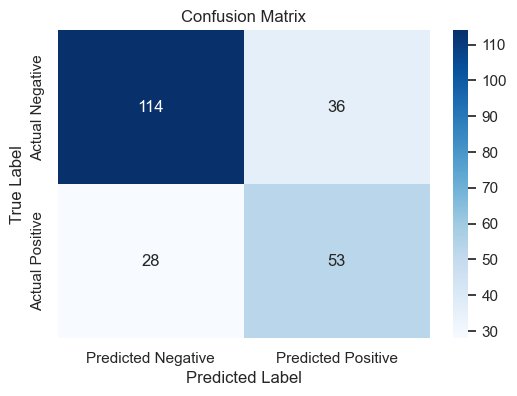

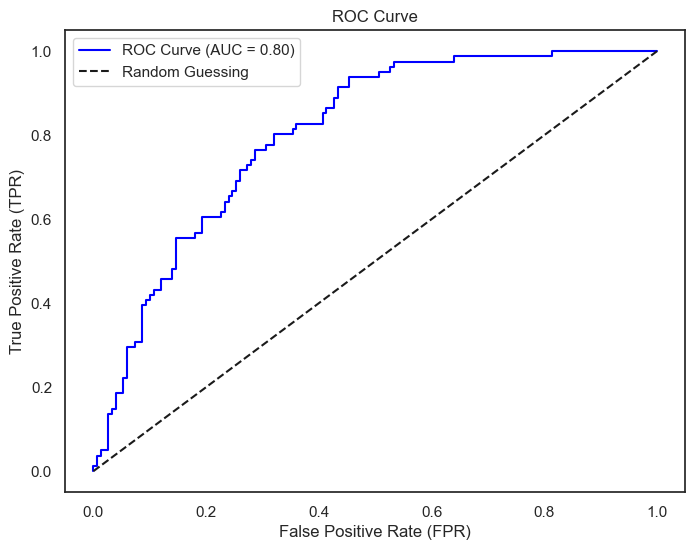

Cross Doğruluk (Accuracy): 0.7460
Cross Kesinlik (Precision): 0.6588
Cross Duyarlılık (Sensitivity/Recall): 0.5932
Cross F1 Skoru: 0.6206
Cross AUC: 0.8087


In [1330]:

from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train_scaled, y_train, sample_weight=sample_weights)

# Make predictions on the testing set
predictions = nb.predict(X_test_scaled)

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, predictions)
print(f"Doğruluk (Accuracy): {accuracy:.4f}")

specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

precision = precision_score(y_test, predictions)
print(f"Kesinlik (Precision): {precision:.4f}")

sensitivity = recall_score(y_test, predictions)
print(f"Duyarlılık (Sensitivity/Recall): {sensitivity:.4f}")

f1 = f1_score(y_test, predictions)
print(f"F1 Skoru: {f1:.4f}")

# Append scores to results
results['Model'].append("NAIVE BAYES")
results['Accuracy'].append(accuracy)
results['Specificity'].append(specificity)
results['Precision'].append(precision)
results['Recall'].append(sensitivity)
results['F1'].append(f1)

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Get predicted probabilities for the positive class
y_probs = nb.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)
results['AUC'].append(auc_score)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()


cross_accuracy = cross_val_score(nb, X, y, cv=skf, scoring='accuracy')
cross_precision = cross_val_score(nb, X, y, cv=skf, scoring='precision')
cross_sensitivity = cross_val_score(nb, X, y, cv=skf, scoring='recall')
cross_f1 = cross_val_score(nb, X, y, cv=skf, scoring='f1')
cross_auc_score = cross_val_score(nb, X, y, cv=skf, scoring='roc_auc')

mean_accuracy = cross_accuracy.mean()
mean_precision = cross_precision.mean()
mean_sensitivity = cross_sensitivity.mean()
mean_f1 = cross_f1.mean()
mean_auc_score = cross_auc_score.mean()


# Append scores to results
cross_results['Model'].append("NAIVE BAYES")
cross_results['Accuracy'].append(mean_accuracy)
cross_results['Precision'].append(mean_precision)
cross_results['Recall'].append(mean_sensitivity)
cross_results['F1'].append(mean_f1)
cross_results['AUC'].append(mean_auc_score)


print(f"Cross Doğruluk (Accuracy): {mean_accuracy:.4f}")
print(f"Cross Kesinlik (Precision): {mean_precision:.4f}")
print(f"Cross Duyarlılık (Sensitivity/Recall): {mean_sensitivity:.4f}")
print(f"Cross F1 Skoru: {mean_f1:.4f}")
print(f"Cross AUC: {mean_auc_score:.4f}")

## 4.1. NAIVE BAYES (PCA)

Doğruluk (Accuracy): 0.7229
Specificity: 0.7267
Kesinlik (Precision): 0.5859
Duyarlılık (Sensitivity/Recall): 0.7160
F1 Skoru: 0.6444


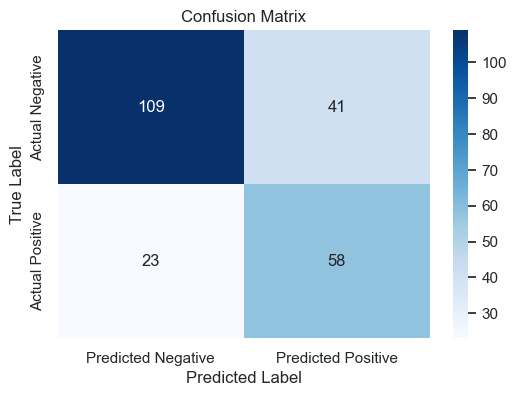

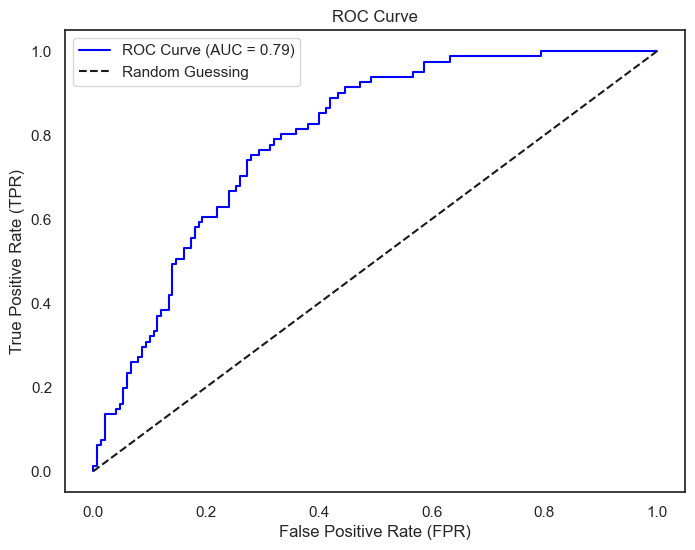

In [1331]:

from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train_pca, y_train, sample_weight=sample_weights)

# Make predictions on the testing set
predictions = nb.predict(X_test_pca)

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, predictions)
print(f"Doğruluk (Accuracy): {accuracy:.4f}")

specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

precision = precision_score(y_test, predictions)
print(f"Kesinlik (Precision): {precision:.4f}")

sensitivity = recall_score(y_test, predictions)
print(f"Duyarlılık (Sensitivity/Recall): {sensitivity:.4f}")

f1 = f1_score(y_test, predictions)
print(f"F1 Skoru: {f1:.4f}")

# Append scores to results
results['Model'].append("NAIVE BAYES (PCA)")
results['Accuracy'].append(accuracy)
results['Specificity'].append(specificity)
results['Precision'].append(precision)
results['Recall'].append(sensitivity)
results['F1'].append(f1)

joblib.dump(nb, "bayes_pca_model.pkl")


# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Get predicted probabilities for the positive class
y_probs = nb.predict_proba(X_test_pca)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)
results['AUC'].append(auc_score)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()


## 4.3. NAIVE BAYES (LDA)

Doğruluk (Accuracy): 0.7532
Specificity: 0.8067
Kesinlik (Precision): 0.6463
Duyarlılık (Sensitivity/Recall): 0.6543
F1 Skoru: 0.6503


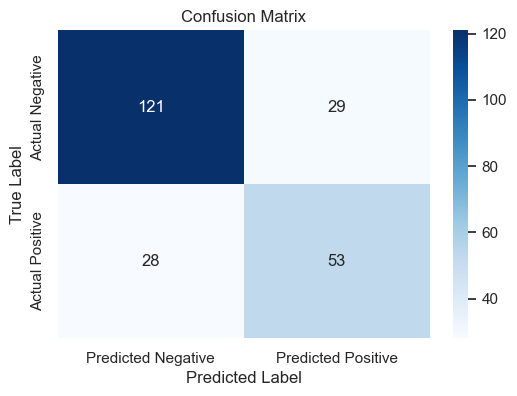

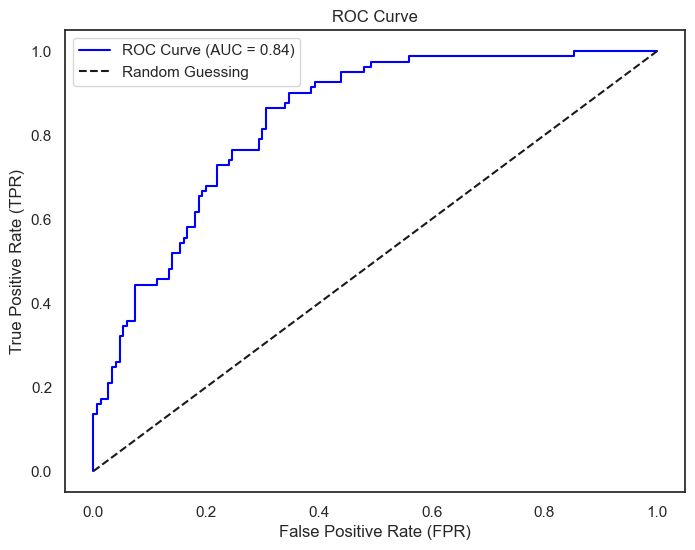

In [1332]:

from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train_lda, y_train, sample_weight=sample_weights)

# Make predictions on the testing set
predictions = nb.predict(X_test_lda)

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, predictions)
print(f"Doğruluk (Accuracy): {accuracy:.4f}")

specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

precision = precision_score(y_test, predictions)
print(f"Kesinlik (Precision): {precision:.4f}")

sensitivity = recall_score(y_test, predictions)
print(f"Duyarlılık (Sensitivity/Recall): {sensitivity:.4f}")

f1 = f1_score(y_test, predictions)
print(f"F1 Skoru: {f1:.4f}")

# Append scores to results
results['Model'].append("NAIVE BAYES (LDA)")
results['Accuracy'].append(accuracy)
results['Specificity'].append(specificity)
results['Precision'].append(precision)
results['Recall'].append(sensitivity)
results['F1'].append(f1)

joblib.dump(nb, "bayes_lda_model.pkl")



# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Get predicted probabilities for the positive class
y_probs = nb.predict_proba(X_test_lda)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)
results['AUC'].append(auc_score)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()


# 5. SUPPORT VECTOR MACHINE

Doğruluk (Accuracy): 0.7532
Specificity: 0.8000
Kesinlik (Precision): 0.6429
Duyarlılık (Sensitivity/Recall): 0.6667
F1 Skoru: 0.6545


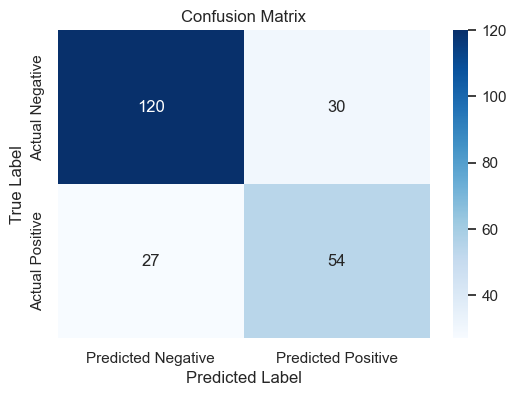

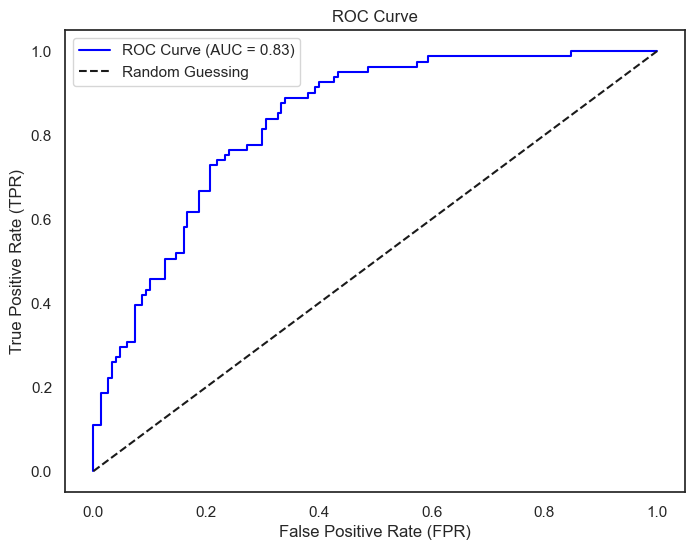

Cross Doğruluk (Accuracy): 0.7395
Cross Kesinlik (Precision): 0.6185
Cross Duyarlılık (Sensitivity/Recall): 0.7088
Cross F1 Skoru: 0.6579
Cross AUC: 0.8337


In [1333]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

# 4. Initialize and Train SVC Model
svm = SVC(kernel='linear', probability=True, random_state=42, class_weight=weights)
svm.fit(X_train_scaled, y_train)

# 5. Make Predictions
predictions = svm.predict(X_test_scaled)

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, predictions)
print(f"Doğruluk (Accuracy): {accuracy:.4f}")

specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

precision = precision_score(y_test, predictions)
print(f"Kesinlik (Precision): {precision:.4f}")

sensitivity = recall_score(y_test, predictions)
print(f"Duyarlılık (Sensitivity/Recall): {sensitivity:.4f}")

f1 = f1_score(y_test, predictions)
print(f"F1 Skoru: {f1:.4f}")


# Append scores to results
results['Model'].append("SUPPORT VECTOR MACHINE")
results['Accuracy'].append(accuracy)
results['Specificity'].append(specificity)
results['Precision'].append(precision)
results['Recall'].append(sensitivity)
results['F1'].append(f1)


# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Get predicted probabilities for the positive class
y_probs = svm.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)
results['AUC'].append(auc_score)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()


cross_accuracy = cross_val_score(svm, X, y, cv=skf, scoring='accuracy')
cross_precision = cross_val_score(svm, X, y, cv=skf, scoring='precision')
cross_sensitivity = cross_val_score(svm, X, y, cv=skf, scoring='recall')
cross_f1 = cross_val_score(svm, X, y, cv=skf, scoring='f1')
cross_auc_score = cross_val_score(svm, X, y, cv=skf, scoring='roc_auc')

mean_accuracy = cross_accuracy.mean()
mean_precision = cross_precision.mean()
mean_sensitivity = cross_sensitivity.mean()
mean_f1 = cross_f1.mean()
mean_auc_score = cross_auc_score.mean()


# Append scores to results
cross_results['Model'].append("SUPPORT VECTOR MACHINE")
cross_results['Accuracy'].append(mean_accuracy)
cross_results['Precision'].append(mean_precision)
cross_results['Recall'].append(mean_sensitivity)
cross_results['F1'].append(mean_f1)
cross_results['AUC'].append(mean_auc_score)


print(f"Cross Doğruluk (Accuracy): {mean_accuracy:.4f}")
print(f"Cross Kesinlik (Precision): {mean_precision:.4f}")
print(f"Cross Duyarlılık (Sensitivity/Recall): {mean_sensitivity:.4f}")
print(f"Cross F1 Skoru: {mean_f1:.4f}")
print(f"Cross AUC: {mean_auc_score:.4f}")

## 5.1. SUPPORT VECTOR MACHINE (PCA)

Doğruluk (Accuracy): 0.7229
Specificity: 0.7267
Kesinlik (Precision): 0.5859
Duyarlılık (Sensitivity/Recall): 0.7160
F1 Skoru: 0.6444


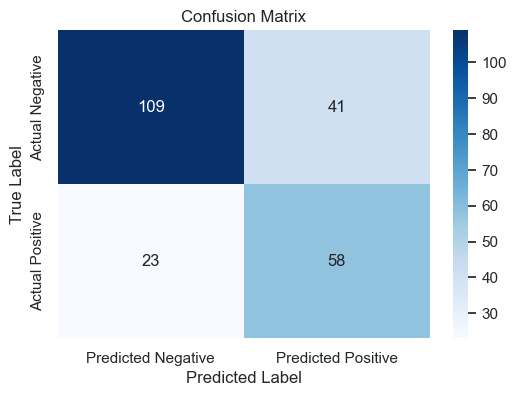

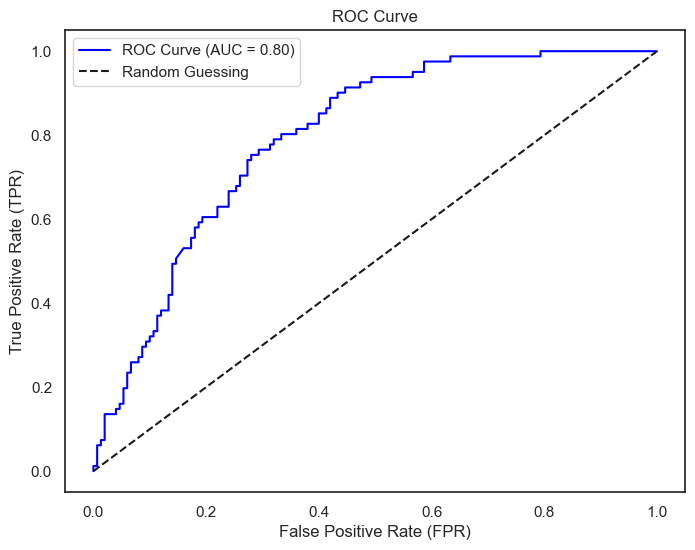

In [1334]:

# 4. Initialize and Train SVC Model
svm = SVC(kernel='linear', probability=True, random_state=42, class_weight=weights)
svm.fit(X_train_pca, y_train)

# 5. Make Predictions
predictions = svm.predict(X_test_pca)

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, predictions)
print(f"Doğruluk (Accuracy): {accuracy:.4f}")

specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

precision = precision_score(y_test, predictions)
print(f"Kesinlik (Precision): {precision:.4f}")

sensitivity = recall_score(y_test, predictions)
print(f"Duyarlılık (Sensitivity/Recall): {sensitivity:.4f}")

f1 = f1_score(y_test, predictions)
print(f"F1 Skoru: {f1:.4f}")

# Append scores to results
results['Model'].append("SUPPORT VECTOR MACHINE (PCA)")
results['Accuracy'].append(accuracy)
results['Specificity'].append(specificity)
results['Precision'].append(precision)
results['Recall'].append(sensitivity)
results['F1'].append(f1)


# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Get predicted probabilities for the positive class
y_probs = svm.predict_proba(X_test_pca)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)
results['AUC'].append(auc_score)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()


## 5.3. SUPPORT VECTOR MACHINE (LDA)

Doğruluk (Accuracy): 0.7532
Specificity: 0.8067
Kesinlik (Precision): 0.6463
Duyarlılık (Sensitivity/Recall): 0.6543
F1 Skoru: 0.6503


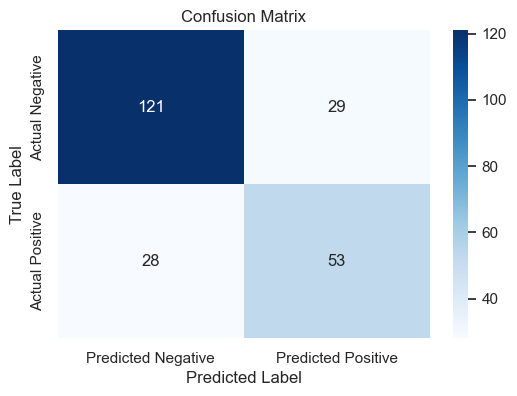

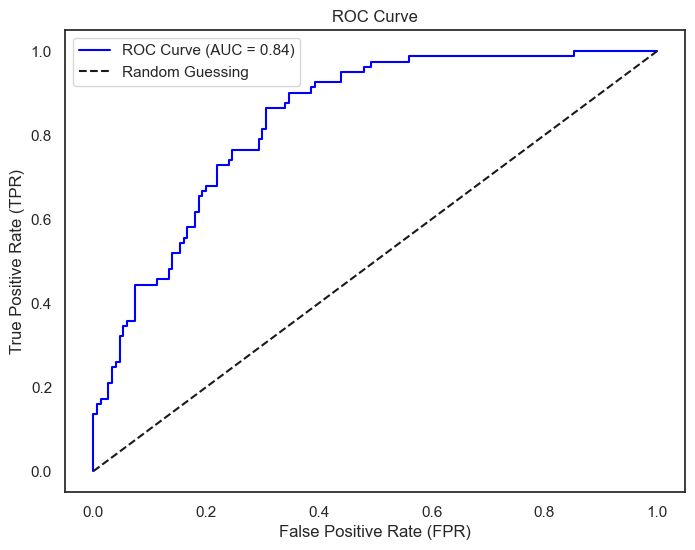

In [1335]:

# 4. Initialize and Train SVC Model
svm = SVC(kernel='linear', probability=True, random_state=42, class_weight=weights)
svm.fit(X_train_lda, y_train)

# 5. Make Predictions
predictions = svm.predict(X_test_lda)

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, predictions)
print(f"Doğruluk (Accuracy): {accuracy:.4f}")

specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

precision = precision_score(y_test, predictions)
print(f"Kesinlik (Precision): {precision:.4f}")

sensitivity = recall_score(y_test, predictions)
print(f"Duyarlılık (Sensitivity/Recall): {sensitivity:.4f}")

f1 = f1_score(y_test, predictions)
print(f"F1 Skoru: {f1:.4f}")

# Append scores to results
results['Model'].append("SUPPORT VECTOR MACHINE (LDA)")
results['Accuracy'].append(accuracy)
results['Specificity'].append(specificity)
results['Precision'].append(precision)
results['Recall'].append(sensitivity)
results['F1'].append(f1)

joblib.dump(svm, "svm_lda_model.pkl")


# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Get predicted probabilities for the positive class
y_probs = svm.predict_proba(X_test_lda)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)
results['AUC'].append(auc_score)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()


# 6. LOGISTIC REGRESSION

Doğruluk (Accuracy): 0.7619
Specificity: 0.7933
Kesinlik (Precision): 0.6477
Duyarlılık (Sensitivity/Recall): 0.7037
F1 Skoru: 0.6746


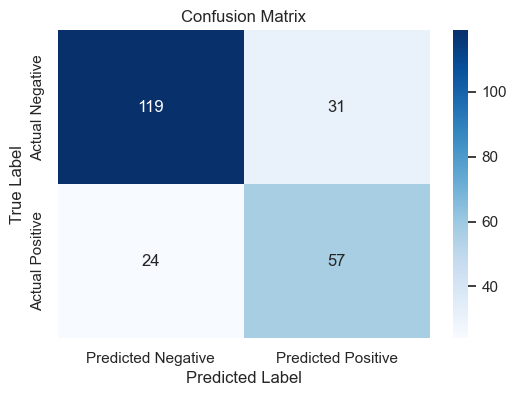

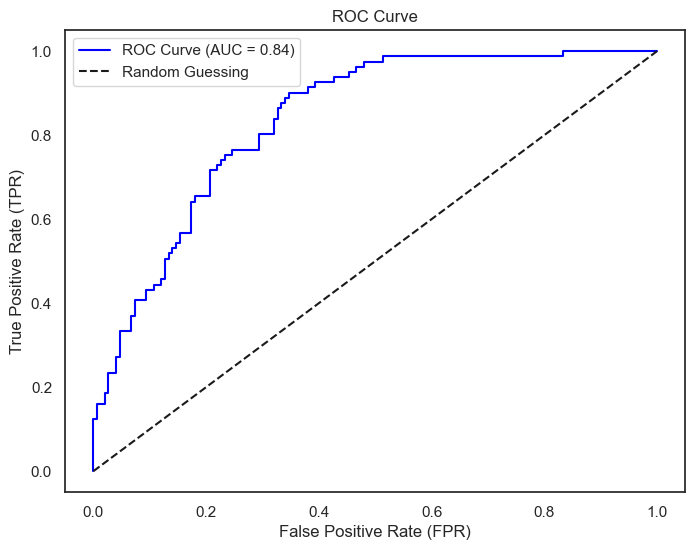

Cross Doğruluk (Accuracy): 0.7499
Cross Kesinlik (Precision): 0.6340
Cross Duyarlılık (Sensitivity/Recall): 0.7164
Cross F1 Skoru: 0.6690
Cross AUC: 0.8263


In [1336]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=42, class_weight=weights)
lr.fit(X_train_scaled,y_train)

# Make predictions on the testing set
predictions = lr.predict(X_test_scaled)

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, predictions)
print(f"Doğruluk (Accuracy): {accuracy:.4f}")

specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

precision = precision_score(y_test, predictions)
print(f"Kesinlik (Precision): {precision:.4f}")

sensitivity = recall_score(y_test, predictions)
print(f"Duyarlılık (Sensitivity/Recall): {sensitivity:.4f}")

f1 = f1_score(y_test, predictions)
print(f"F1 Skoru: {f1:.4f}")


# Append scores to results
results['Model'].append("LOGISTIC REGRESSION")
results['Accuracy'].append(accuracy)
results['Specificity'].append(specificity)
results['Precision'].append(precision)
results['Recall'].append(sensitivity)
results['F1'].append(f1)

joblib.dump(lr, "lr_model.pkl")


# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Get predicted probabilities for the positive class
y_probs = lr.predict_proba(X_test_scaled)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)
results['AUC'].append(auc_score)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()


cross_accuracy = cross_val_score(lr, X, y, cv=skf, scoring='accuracy')
cross_precision = cross_val_score(lr, X, y, cv=skf, scoring='precision')
cross_sensitivity = cross_val_score(lr, X, y, cv=skf, scoring='recall')
cross_f1 = cross_val_score(lr, X, y, cv=skf, scoring='f1')
cross_auc_score = cross_val_score(lr, X, y, cv=skf, scoring='roc_auc')

mean_accuracy = cross_accuracy.mean()
mean_precision = cross_precision.mean()
mean_sensitivity = cross_sensitivity.mean()
mean_f1 = cross_f1.mean()
mean_auc_score = cross_auc_score.mean()


# Append scores to results
cross_results['Model'].append("LOGISTIC REGRESSION")
cross_results['Accuracy'].append(mean_accuracy)
cross_results['Precision'].append(mean_precision)
cross_results['Recall'].append(mean_sensitivity)
cross_results['F1'].append(mean_f1)
cross_results['AUC'].append(mean_auc_score)


print(f"Cross Doğruluk (Accuracy): {mean_accuracy:.4f}")
print(f"Cross Kesinlik (Precision): {mean_precision:.4f}")
print(f"Cross Duyarlılık (Sensitivity/Recall): {mean_sensitivity:.4f}")
print(f"Cross F1 Skoru: {mean_f1:.4f}")
print(f"Cross AUC: {mean_auc_score:.4f}")

## 6.1. LOGISTIC REGRESSION (PCA)

Doğruluk (Accuracy): 0.7229
Specificity: 0.7333
Kesinlik (Precision): 0.5876
Duyarlılık (Sensitivity/Recall): 0.7037
F1 Skoru: 0.6404


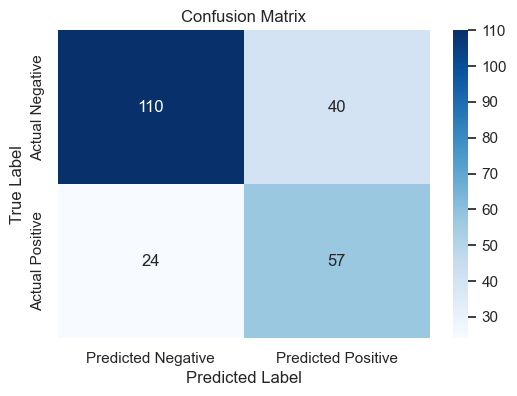

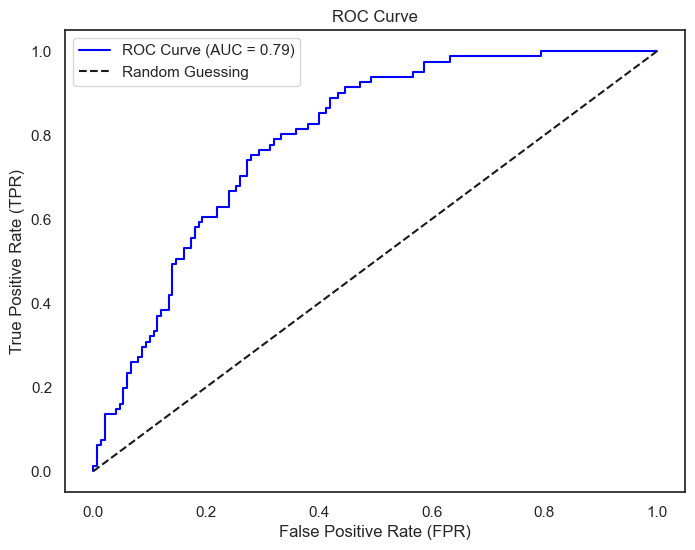

In [1337]:

lr = LogisticRegression(random_state=42, class_weight=weights)
lr.fit(X_train_pca,y_train)

# Make predictions on the testing set
predictions = lr.predict(X_test_pca)

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, predictions)
print(f"Doğruluk (Accuracy): {accuracy:.4f}")

specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

precision = precision_score(y_test, predictions)
print(f"Kesinlik (Precision): {precision:.4f}")

sensitivity = recall_score(y_test, predictions)
print(f"Duyarlılık (Sensitivity/Recall): {sensitivity:.4f}")

f1 = f1_score(y_test, predictions)
print(f"F1 Skoru: {f1:.4f}")

# Append scores to results
results['Model'].append("LOGISTIC REGRESSION (PCA)")
results['Accuracy'].append(accuracy)
results['Specificity'].append(specificity)
results['Precision'].append(precision)
results['Recall'].append(sensitivity)
results['F1'].append(f1)


# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Get predicted probabilities for the positive class
y_probs = lr.predict_proba(X_test_pca)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)
results['AUC'].append(auc_score)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()


## 6.3. LOGISTIC REGRESSION (LDA)

{np.int64(0), np.int64(1)}
Doğruluk (Accuracy): 0.7532
Specificity: 0.7800
Kesinlik (Precision): 0.6333
Duyarlılık (Sensitivity/Recall): 0.7037
F1 Skoru: 0.6667


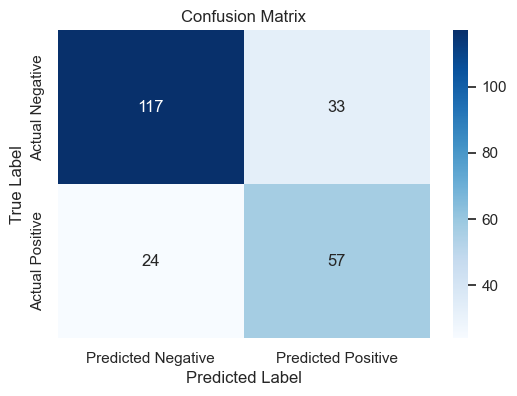

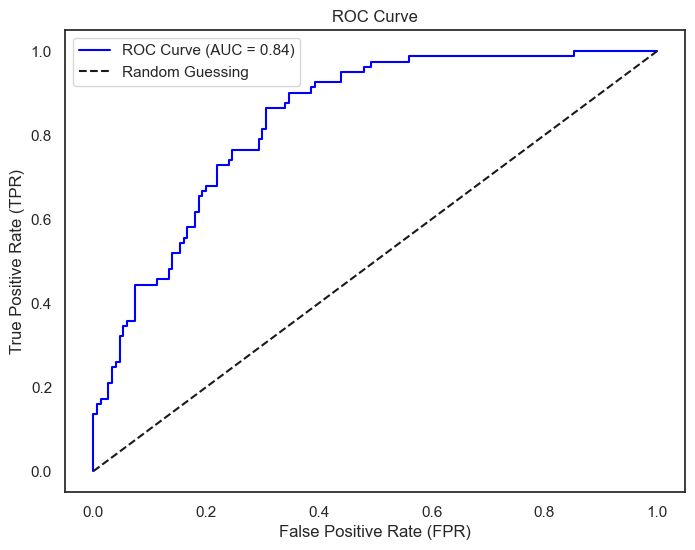

In [1338]:

lr = LogisticRegression(random_state=42, class_weight=weights)
lr.fit(X_train_lda,y_train)

# Make predictions on the testing set
predictions = lr.predict(X_test_lda)
print(set(predictions))

# Confusion Matrix
cm = confusion_matrix(y_test, predictions)

tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, predictions)
print(f"Doğruluk (Accuracy): {accuracy:.4f}")

specificity = tn / (tn + fp)
print(f"Specificity: {specificity:.4f}")

precision = precision_score(y_test, predictions)
print(f"Kesinlik (Precision): {precision:.4f}")

sensitivity = recall_score(y_test, predictions)
print(f"Duyarlılık (Sensitivity/Recall): {sensitivity:.4f}")

f1 = f1_score(y_test, predictions)
print(f"F1 Skoru: {f1:.4f}")

# Append scores to results
results['Model'].append("LOGISTIC REGRESSION (LDA)")
results['Accuracy'].append(accuracy)
results['Specificity'].append(specificity)
results['Precision'].append(precision)
results['Recall'].append(sensitivity)
results['F1'].append(f1)

joblib.dump(lr, "lr_lda_model.pkl")


# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Get predicted probabilities for the positive class
y_probs = lr.predict_proba(X_test_lda)[:, 1]

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)
results['AUC'].append(auc_score)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [1339]:
# Convert to DataFrame

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
results_df = pd.DataFrame(results)
print(results_df)

# Excel olarak kaydet
results_df.to_excel('results.xlsx', index=False)

# Excel dosyasını oku
df = pd.read_excel("results.xlsx", engine='openpyxl')

# Tüm sayısal sütunları 2 ondalık basamağa yuvarla
df = df.round(2)

# VEYA belirli bir sütunu yuvarla
# df["sütun_adı"] = df["sütun_adı"].round(2)

# Yuvarlanmış veriyi yeni bir Excel dosyasına yaz
df.to_excel("results.xlsx", index=False, engine='openpyxl')

                           Model        F1  Accuracy       AUC  Specificity  \
0                            MLP  0.526316  0.688312  0.755473     0.793333   
1                      MLP (PCA)  0.521739  0.714286  0.794979     0.860000   
2                      MLP (LDA)  0.536232  0.722944  0.827984     0.866667   
3                  Decision Tree  0.560976  0.688312  0.660617     0.753333   
4            Decision Tree (PCA)  0.506667  0.679654  0.631235     0.793333   
5            Decision Tree (LDA)  0.594937  0.722944  0.690123     0.800000   
6            K-NEAREST NEIGHBOOR  0.575163  0.718615  0.678272     0.813333   
7      K-NEAREST NEIGHBOOR (PCA)  0.506667  0.679654  0.631235     0.793333   
8      K-NEAREST NEIGHBOOR (LDA)  0.594937  0.722944  0.690123     0.800000   
9                    NAIVE BAYES  0.623529  0.722944  0.803786     0.760000   
10             NAIVE BAYES (PCA)  0.644444  0.722944  0.794979     0.726667   
11             NAIVE BAYES (LDA)  0.650307  0.753247

In [1340]:
# Convert to DataFrame
results_df = pd.DataFrame(cross_results)
print(results_df)

# Excel olarak kaydet
results_df.to_excel('cross_results.xlsx', index=False)

# Excel dosyasını oku
df = pd.read_excel("cross_results.xlsx", engine='openpyxl')

# Tüm sayısal sütunları 2 ondalık basamağa yuvarla
df = df.round(2)

# VEYA belirli bir sütunu yuvarla
# df["sütun_adı"] = df["sütun_adı"].round(2)

# Yuvarlanmış veriyi yeni bir Excel dosyasına yaz
df.to_excel("cross_results.xlsx", index=False, engine='openpyxl')

                    Model        F1  Accuracy       AUC  Precision    Recall
0                     MLP  0.398631  0.677031  0.677783   0.630882  0.352411
1               MLP (PCA)  0.398631  0.677031  0.677783   0.630882  0.352411
2           Decision Tree  0.560658  0.695230  0.663630   0.567071  0.559259
3      K-NEAREST NEIGHBOR  0.552317  0.690069  0.657423   0.560366  0.548847
4             NAIVE BAYES  0.620552  0.746023  0.808747   0.658805  0.593152
5  SUPPORT VECTOR MACHINE  0.657870  0.739462  0.833695   0.618472  0.708805
6     LOGISTIC REGRESSION  0.669047  0.749936  0.826312   0.634023  0.716352
